### Loading libs

In [1]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from latentcor import gen_data, get_tps, latentcor

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

### Reading data

In [2]:
# load
data = pd.read_csv('./sim-data/trans_series.csv', index_col=0).to_numpy(dtype="float32")

# split 
data_train = data[:1000]
data_test = data[1000:]

In [3]:
class Data(Dataset):
  def __init__(self, data, length):
    # init
    self.data = data
    self.length = length
  
  def __getitem__(self, index):
    return self.data[index:(index+self.length)]
  
  def __len__(self):
    return self.data.shape[0]-self.length-1

In [4]:
# scale
scaler = StandardScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [67]:
# create data loader for training data
length = 300
data_train_loader = Data(data_train, length)
data_train_loader = DataLoader(data_train_loader, batch_size=32, shuffle=True)

In [68]:
# overlap
start = 0
index = 0
overlap = 10
X = np.empty(((data_train.shape[0] - length) // overlap+1, length))
while (start+length) <= data_train.shape[0]:
    X[index, :] = data_train[start:(start+length), 0]
    index = index + 1
    start = start + overlap
    
cov = latentcor(X, tps=['con']*length)[0]

/Users/renatsergazinov/anaconda3/envs/torch/lib/python3.9/site-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


In [69]:
X.shape

(71, 300)

In [70]:
cov

array([[ 1.        ,  0.7366886 ,  0.66604148, ..., -0.1432364 ,
        -0.12473192, -0.22308723],
       [ 0.7366886 ,  1.        ,  0.69074807, ...,  0.00701544,
         0.02898143, -0.00736099],
       [ 0.66604148,  0.69074807,  1.        , ..., -0.23893464,
        -0.29080826, -0.27225675],
       ...,
       [-0.1432364 ,  0.00701544, -0.23893464, ...,  1.        ,
         0.8558823 ,  0.81633066],
       [-0.12473192,  0.02898143, -0.29080826, ...,  0.8558823 ,
         1.        ,  0.82984847],
       [-0.22308723, -0.00736099, -0.27225675, ...,  0.81633066,
         0.82984847,  1.        ]])

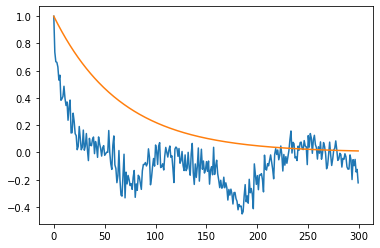

In [71]:
plt.plot(cov[0, :])
plt.plot(np.array([0.985**i for i in range(length)]))

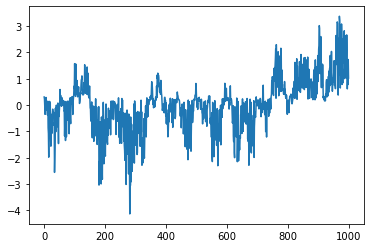

In [9]:
plt.plot(data_train)

### Define model

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        x = self.g(z)
        return x

In [ ]:
nets = lambda: nn.Sequential(nn.Linear(268, 512), nn.LeakyReLU(), nn.Linear(512, 512), nn.LeakyReLU(), nn.Linear(512, 268), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(268, 512), nn.LeakyReLU(), nn.Linear(512, 512), nn.LeakyReLU(), nn.Linear(512, 268))
masks = torch.from_numpy(np.array([[0]*134 + [1]*134, [1]*134 + [0]*134] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(268), torch.tensor(cov))
flow = RealNVP(nets, nett, masks, prior)

In [ ]:
EPOCHS = 4000
TRAIN_STEPS = len(data_train_loader)
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)

for epoch in range(EPOCHS):
    iter_count = 0
    train_loss = []

    epoch_time = time.time()
    curr_time = time.time()

    for i, sample in enumerate(data_train_loader):
        iter_count += 1
        loss = -flow.log_prob(sample).mean()
        train_loss.append(loss.item())

        print('\titers: {0}, epoch: {1} | loss: {2:.7f}'.format(i, epoch + 1, loss.item()))
        speed = (time.time() - curr_time) / iter_count
        left_time = speed * ((EPOCHS - epoch) * TRAIN_STEPS - i)
        print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            for param in flow.parameters():
                param.clamp_(1e-14, 1e14)

    # compute average train loss
    train_loss = np.average(train_loss)
    
    print("epoch: {}, epoch time: {}, loss: {}".format(epoch+1, time.time() - curr_time, train_loss))

In [ ]:
# predict last 24

pred_cov = cov[-24:, -24:] - cov[-24:, :-24] @ np.linalg.inv(cov[:-24, :-24]) @ cov[:-24, -24:]
pred = np.empty([data_test.shape[0], data_test.shape[1]])
pred_upper = np.empty([data_test.shape[0], data_test.shape[1]])
pred_lower = np.empty([data_test.shape[0], data_test.shape[1]])

for index in range(data_test.shape[0]):
    # pad with mean
    sample = np.concatenate((data_test[index, :-24], [np.mean(data_test[index, :-24])]*24))[np.newaxis, :]
    # iterate prediction step until convergence
    print('Index: {0}'.format(index))
    for i in range(5):
        z, logp = flow.f(torch.from_numpy(sample))
        print('\tlog prob: {0:.4f}'.format(logp.item()))
        z = z.detach().numpy()[0]
        zhat = cov[-24:, :-24] @ np.linalg.inv(cov[:-24, :-24]) @ z[:-24]
        z = np.concatenate((z[:-24], zhat))
        sample = flow.g(torch.from_numpy(z[np.newaxis, :])).detach().numpy()
    # compute confidence band
    z_upper = np.concatenate((z[:-24], zhat + 2*np.sqrt(np.diag(pred_cov))))
    z_lower = np.concatenate((z[:-24], zhat - 2*np.sqrt(np.diag(pred_cov))))
    sample_upper = flow.g(torch.from_numpy(z_lower[np.newaxis, :])).detach().numpy()
    sample_lower = flow.g(torch.from_numpy(z_upper[np.newaxis, :])).detach().numpy()
    # save results
    pred[index, :] = sample[0, :]; pred_lower[index, :] = sample_lower[0, :]; pred_upper[index, :] = sample_upper[0, :]

In [ ]:
true = scaler.inverse_transform(data_test)[:, -24:]
pred = scaler.inverse_transform(pred)[:, -24:]
pred_lower = scaler.inverse_transform(pred_lower)[:, -24:]
pred_upper = scaler.inverse_transform(pred_upper)[:, -24:]
print(np.mean((true - pred)**2))

In [ ]:
index = 1
plt.plot(true[index, :], color='red')
plt.plot(pred[index, :], color='blue')
plt.plot(pred_lower[index, :], color='blue')
plt.plot(pred_upper[index, :], color='blue')

In [ ]:
plt.hist(np.mean((true-pred)**2, axis = 1))